# Training ANN for predicting shear resistance of concrete beams reinforced by FRP bars

Reference: Shear resistance prediction of concrete beams reinforced by FRP bars using artificial neural networks
https://doi.org/10.1016/j.measurement.2018.05.051

The data from Table A1 of the above paper are saved into train_data.xlsx and loaded in this script for training an ANN using two different training algortihms: Adam and Levenberg-Marquardt. The data contains 6 input variables and one output variable. The latter is the shear resistance calculated according to ACI440.1R.

The fitting is done with a shallow neural network. This script is adjusted from the script published at https://github.com/fabiodimarco/tf-levenberg-marquardt . In this script it is shown that first-order methods such as Adam fail to converge, while Levenberg–Marquardt converges rapidly with very low loss values. The values of learning_rate were chosen experimentally on the basis of the results obtained by each algorithm.


In [63]:
import os
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
# If the module levenberg_marquardt cannot be imported in Google Collab, then You can do this by clicking on the “Files” button on the left-hand side of the Colab interface, and then clicking on the “Upload” button. Once you have uploaded the module file (levenberg_marquardt.py), you can import it in your Colab notebook using a standard Python import statement.
import levenberg_marquardt as lm

In [64]:
input_size = 177  # Update this to match the size of your dataset
batch_size = 18
# Get the directory where this script is located
script_dir=os.getcwd()
print(script_dir)
# Construct the relative path to the Excel file
relative_file_path = 'train_data.xlsx'
excel_file_path = os.path.join(script_dir, relative_file_path)
print(excel_file_path)
# Load training data from Excel file
# If the data cannot be loaded in Google Collab, then upload the Excel file by clicking on the “Files” button on the left-hand side of the Colab interface, and then clicking on the “Upload” button.
train_data = pd.read_excel(excel_file_path, skiprows=0)
# Print dimensions of the data being loaded
print(train_data.shape)
# Separate input and output training data
x_train = train_data.iloc[:, :-1].values
y_train = train_data.iloc[:, -1].values
# Print dimensions of the x data
print(x_train.shape)
# Print dimensions of the y data
print(y_train.shape)
#print(x_train)
#print(y_train)
# Normalize x data
max_values = np.max(x_train, axis=0)
x_train = x_train / max_values
print(max_values)
#print(x_train)
# Normalize y data
max_values = np.max(y_train, axis=0)
y_train = y_train / max_values
print(max_values)
#print(y_train)

# Assign the first 160 observations to training data and the rest 17 observations for testing data
# X-data
x_test=x_train[160:177, 0:6]
x_train=x_train[0:160, 0:6]
print(x_test.shape)
print(x_train.shape)
#print(x_test)
#print(x_train)
# Y-data
y_test=y_train[160:177]
y_train=y_train[0:160]
print(y_test.shape)
print(y_train.shape)
#print(x_test)
#print(x_train)

/content
/content/train_data.xlsx
(177, 7)
(177, 6)
(177,)
[457.   594.     4.5   88.3    3.02 147.9 ]
538.2783419303111
(17, 6)
(160, 6)
(17,)
(160,)


In [65]:
# Convert data to TensorFlow tensors
x_train = tf.constant(x_train, dtype=tf.float32)
y_train = tf.constant(y_train, dtype=tf.float32)
#print(x_train)
#print(y_train)

In [66]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(input_size)
train_dataset = train_dataset.batch(batch_size).cache()
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
print(train_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


In [67]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation='tanh', input_shape=(6,)),
    tf.keras.layers.Dense(1, activation='linear')])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.MeanSquaredError())

model_wrapper = lm.ModelWrapper(
    tf.keras.models.clone_model(model))

model_wrapper.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
    loss=lm.MeanSquaredError())


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 20)                140       
                                                                 
 dense_9 (Dense)             (None, 1)                 21        
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [68]:
print("Train using Adam")
t1_start = time.perf_counter()
model.fit(train_dataset, epochs=1000)
t1_stop = time.perf_counter()
print("Elapsed time: ", t1_stop - t1_start)
# loss value: 2.0443e-04

Train using Adam
Epoch 1/1000
9/9 [==============================] - 1s 3ms/step - loss: 0.0279
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 3/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.0066
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 7/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.0034
Epoch 8/1000
9/9 [==============================] - 0s 4ms/step - loss: 0.0031
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 10/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0027
Epoch 11/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 12/1000
9/9 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 13/1000
9/9 [=============

In [69]:
print("\n_________________________________________________________________")
print("Train using Levenberg-Marquardt")
t2_start = time.perf_counter()
model_wrapper.fit(train_dataset, epochs=100)
t2_stop = time.perf_counter()
print("Elapsed time: ", t2_stop - t2_start)
#loss value: 2.3174e-05


_________________________________________________________________
Train using Levenberg-Marquardt
Epoch 1/100
9/9 [==============================] - 1s 52ms/step - damping_factor: 1.0000e-10 - attempts: 1.0000 - loss: 0.0303
Epoch 2/100
9/9 [==============================] - 0s 21ms/step - damping_factor: 1.0000e-10 - attempts: 1.0000 - loss: 0.0053
Epoch 3/100
9/9 [==============================] - 0s 21ms/step - damping_factor: 1.0000e-10 - attempts: 1.0000 - loss: 0.0012
Epoch 4/100
9/9 [==============================] - 0s 23ms/step - damping_factor: 1.0000e-10 - attempts: 1.0000 - loss: 3.6720e-04
Epoch 5/100
9/9 [==============================] - 0s 20ms/step - damping_factor: 1.0000e-10 - attempts: 1.0000 - loss: 1.8530e-04
Epoch 6/100
9/9 [==============================] - 0s 19ms/step - damping_factor: 1.0000e-10 - attempts: 1.0000 - loss: 1.2919e-04
Epoch 7/100
9/9 [==============================] - 0s 22ms/step - damping_factor: 1.0000e-10 - attempts: 1.0000 - loss: 1.0484e


_________________________________________________________________
Plot results
1/1 [==============================] - 0s 20ms/step


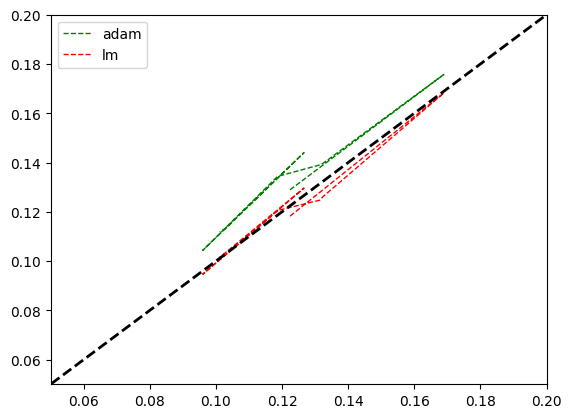

In [71]:
print("\n_________________________________________________________________")
print("Plot results")

plt.plot(y_test, model.predict(x_test), 'g--', label="adam", linewidth=1)
plt.plot(y_test, model_wrapper.predict(x_test), 'r--', label="lm", linewidth=1)
plt.legend()
#plt.axis('equal')
plt.xlim([0.05, 0.2])  # Set your desired x-axis limits
plt.ylim([0.05, 0.2])   # Set your desired y-axis limits
# Add a diagonal dashed line
x = np.linspace(0, 1, 100)
y = x
plt.plot(x, y, linestyle='dashed', color='black', linewidth=2, label='Diagonal Line')

plt.show()
